In [1]:
from river.datasets import ImageSegments
from river.preprocessing import MinMaxScaler
from river.tree import HoeffdingTreeClassifier
from deep_river.classification import Classifier
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.manifold import TSNE

random.seed(0)

### Create Stream

In [2]:
stream_size = 10_000

x, y = list(zip(*ImageSegments()))
x = np.array(x)
y = np.array(y)

# Divide classes into two task specific sets
task_classes = [
    ["brickface", "window", "cement"],
    ["sky", "foliage", "path", "grass"],
]

# Divide all samples into their specific tasks
data_train = []
data_test = []
for classes_t in task_classes:
    x_t = np.concatenate([x[y == c] for c in classes_t])
    y_t = np.concatenate([330 * [c] for c in classes_t])
    x_train, x_test, y_train, y_test = train_test_split(
        x_t, y_t, test_size=0.25, stratify=y_t
    )
    x_train, y_train = resample(
        x_train, y_train, n_samples=int(stream_size / 2), stratify=y_train
    )
    data_train.append(list(zip(x_train, y_train)))
    data_test.append(list(zip(x_test, y_test)))

data_train = data_train[0] + data_train[1]

### Visualize Data

In [3]:
classnames = task_classes[0] + task_classes[1]
tsne = TSNE(init="pca", learning_rate="auto", n_jobs=-1)
x_array = np.array([list(x_i.values()) for x_i in x])
x_viz = tsne.fit_transform(x_array)

/Users/cedrickulbach/Documents/Environments/deep-river/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


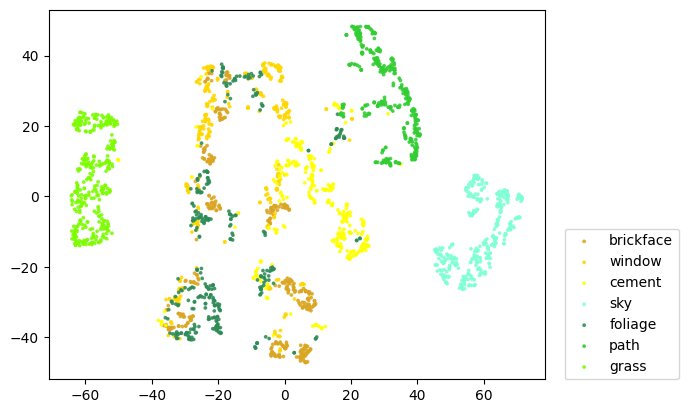

In [4]:
fig, ax = plt.subplots()
cm = [
    "goldenrod",
    "gold",
    "yellow",
    "aquamarine",
    "seagreen",
    "limegreen",
    "lawngreen",
]
for c_idx, x_c in enumerate([x_viz[y == c] for c in classnames]):
    scatter = ax.scatter(
        x_c[:, 0],
        x_c[:, 1],
        c=len(x_c) * [cm[c_idx]],
        s=3,
        alpha=0.8,
        label=classnames[c_idx],
    )

ax.legend(loc=(1.04, 0))

### Define evaluation procedure

In [5]:
# Define function to calculate accuracy on testing data for each task
def get_test_accuracy(model, data_test):
    results = []
    for data_test_i in data_test:
        ys = []
        y_preds = []
        for x_test, y_test in data_test_i:
            ys.append(y_test)
            y_preds.append(model.predict_one(x_test))
        accuracy = accuracy_score(ys, y_preds)
        results.append(accuracy)
    return results


# Define training and testing loop
def eval_separate_testing(model, data_train, data_test):
    scaler = MinMaxScaler()
    step = 0
    steps = []
    results = [[] for task in data_test]
    for x, y in tqdm(data_train):
        step += 1
        scaler.learn_one(x)
        x = scaler.transform_one(x)
        model.learn_one(x, y)

        if step % 100 == 0:
            test_accuracies = get_test_accuracy(model, data_test)
            for idx, accuracy in enumerate(test_accuracies):
                results[idx].append(accuracy)
            steps.append(step)
    return steps, results

## Evaluate Classifiers

In [6]:
# Evaluate a simple MLP classifier
class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.hidden1 = nn.Linear(n_features, 30)
        self.logits = nn.Linear(30, 7)

    def forward(self, x):
        h = torch.relu(self.hidden1(x))
        return self.logits(h)


mlp = Classifier(
    SimpleMLP,
    loss_fn="binary_cross_entropy_with_logits",
    optimizer_fn="sgd",
    lr=0.05,
    seed=42,
)
steps, results_mlp = eval_separate_testing(mlp, data_train, data_test)

  0%|                                                                                                                                                                                                                    | 0/10000 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                                          | 1/10000 [00:00<2:28:01,  1.13it/s]

  1%|██                                                                                                                                                                                                       | 100/10000 [00:00<01:12, 136.08it/s]

  2%|████                                                                                                                                                                                                     | 200/10000 [00:01<00:35, 276.45it/s]

  3%|██████▍                                                                                                                                                                                                  | 318/10000 [00:01<00:21, 446.85it/s]

  4%|████████▋                                                                                                                                                                                                | 434/10000 [00:01<00:15, 597.98it/s]

  5%|██████████▋                                                                                                                                                                                              | 534/10000 [00:01<00:13, 681.07it/s]

  6%|████████████▋                                                                                                                                                                                            | 632/10000 [00:01<00:12, 754.29it/s]

  7%|██████████████▋                                                                                                                                                                                          | 730/10000 [00:01<00:11, 812.08it/s]

  8%|████████████████▉                                                                                                                                                                                        | 845/10000 [00:01<00:10, 903.20it/s]

  9%|███████████████████                                                                                                                                                                                      | 949/10000 [00:01<00:10, 873.22it/s]

 10%|████████████████████▉                                                                                                                                                                                   | 1046/10000 [00:01<00:10, 868.25it/s]

 11%|██████████████████████▊                                                                                                                                                                                 | 1140/10000 [00:02<00:10, 854.81it/s]

 12%|████████████████████████▌                                                                                                                                                                               | 1230/10000 [00:02<00:10, 834.52it/s]

 13%|██████████████████████████▍                                                                                                                                                                             | 1319/10000 [00:02<00:10, 849.38it/s]

 14%|████████████████████████████▏                                                                                                                                                                           | 1407/10000 [00:02<00:12, 711.37it/s]

 15%|██████████████████████████████                                                                                                                                                                          | 1500/10000 [00:02<00:12, 673.29it/s]

 16%|████████████████████████████████                                                                                                                                                                        | 1600/10000 [00:02<00:11, 703.62it/s]

 17%|██████████████████████████████████                                                                                                                                                                      | 1700/10000 [00:02<00:11, 711.87it/s]

 18%|████████████████████████████████████                                                                                                                                                                    | 1800/10000 [00:03<00:12, 681.22it/s]

 19%|█████████████████████████████████████▌                                                                                                                                                                  | 1881/10000 [00:03<00:11, 710.62it/s]

 20%|███████████████████████████████████████                                                                                                                                                                 | 1955/10000 [00:03<00:11, 704.92it/s]

 20%|████████████████████████████████████████▌                                                                                                                                                               | 2027/10000 [00:03<00:14, 554.00it/s]

 21%|██████████████████████████████████████████                                                                                                                                                              | 2100/10000 [00:03<00:13, 582.17it/s]

 22%|████████████████████████████████████████████                                                                                                                                                            | 2200/10000 [00:03<00:11, 668.57it/s]

 23%|██████████████████████████████████████████████                                                                                                                                                          | 2300/10000 [00:03<00:10, 727.94it/s]

 24%|████████████████████████████████████████████████                                                                                                                                                        | 2400/10000 [00:03<00:09, 775.77it/s]

 25%|██████████████████████████████████████████████████                                                                                                                                                      | 2500/10000 [00:04<00:09, 807.18it/s]

 26%|████████████████████████████████████████████████████                                                                                                                                                    | 2600/10000 [00:04<00:08, 848.51it/s]

 27%|██████████████████████████████████████████████████████                                                                                                                                                  | 2700/10000 [00:04<00:08, 863.76it/s]

 28%|████████████████████████████████████████████████████████                                                                                                                                                | 2800/10000 [00:04<00:08, 866.08it/s]

 29%|█████████████████████████████████████████████████████████▉                                                                                                                                              | 2900/10000 [00:04<00:08, 866.89it/s]

 30%|████████████████████████████████████████████████████████████                                                                                                                                            | 3000/10000 [00:04<00:07, 895.50it/s]

 31%|██████████████████████████████████████████████████████████████                                                                                                                                          | 3100/10000 [00:04<00:07, 894.31it/s]

 32%|████████████████████████████████████████████████████████████████                                                                                                                                        | 3200/10000 [00:04<00:07, 865.15it/s]

 33%|██████████████████████████████████████████████████████████████████                                                                                                                                      | 3300/10000 [00:04<00:07, 879.90it/s]

 34%|████████████████████████████████████████████████████████████████████                                                                                                                                    | 3400/10000 [00:05<00:07, 878.22it/s]

 35%|██████████████████████████████████████████████████████████████████████                                                                                                                                  | 3500/10000 [00:05<00:07, 902.24it/s]

 36%|████████████████████████████████████████████████████████████████████████                                                                                                                                | 3600/10000 [00:05<00:07, 907.48it/s]

 37%|██████████████████████████████████████████████████████████████████████████                                                                                                                              | 3700/10000 [00:05<00:06, 913.16it/s]

 38%|████████████████████████████████████████████████████████████████████████████                                                                                                                            | 3800/10000 [00:05<00:06, 912.53it/s]

 39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                          | 3900/10000 [00:05<00:06, 911.61it/s]

 40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 4000/10000 [00:05<00:06, 925.56it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 4100/10000 [00:05<00:06, 937.07it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 4208/10000 [00:05<00:05, 977.60it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 4307/10000 [00:05<00:06, 933.34it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 4402/10000 [00:06<00:05, 936.85it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 4500/10000 [00:06<00:05, 922.24it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 4604/10000 [00:06<00:05, 955.78it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 4708/10000 [00:06<00:05, 979.66it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 4807/10000 [00:06<00:05, 942.31it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 4902/10000 [00:06<00:05, 917.11it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 5006/10000 [00:06<00:05, 951.61it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 5102/10000 [00:06<00:05, 930.82it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 5200/10000 [00:06<00:05, 935.52it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 5300/10000 [00:07<00:04, 952.07it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 5401/10000 [00:07<00:04, 966.93it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 5500/10000 [00:07<00:04, 955.22it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 5609/10000 [00:07<00:04, 993.92it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 5709/10000 [00:07<00:04, 954.38it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 5809/10000 [00:07<00:04, 966.76it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 5907/10000 [00:07<00:04, 963.51it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 6025/10000 [00:07<00:03, 1026.60it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 6134/10000 [00:07<00:03, 1044.94it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 6250/10000 [00:07<00:03, 1078.73it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 6360/10000 [00:08<00:03, 1084.69it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 6475/10000 [00:08<00:03, 1103.64it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 6598/10000 [00:08<00:02, 1140.12it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 6713/10000 [00:08<00:03, 980.14it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 6816/10000 [00:08<00:03, 987.01it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 6929/10000 [00:08<00:02, 1025.46it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 7047/10000 [00:08<00:02, 1068.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 7157/10000 [00:08<00:02, 1076.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 7268/10000 [00:08<00:02, 1086.23it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 7378/10000 [00:09<00:02, 1086.70it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 7498/10000 [00:09<00:02, 1119.42it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 7611/10000 [00:09<00:02, 963.39it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 7717/10000 [00:09<00:02, 987.32it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7819/10000 [00:09<00:02, 985.71it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7923/10000 [00:09<00:02, 1000.29it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 8030/10000 [00:09<00:01, 1019.68it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 8145/10000 [00:09<00:01, 1055.62it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 8252/10000 [00:09<00:01, 1055.90it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 8364/10000 [00:09<00:01, 1073.34it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 8477/10000 [00:10<00:01, 1089.40it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8599/10000 [00:10<00:01, 1127.08it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8713/10000 [00:10<00:01, 978.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8832/10000 [00:10<00:01, 1035.01it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8939/10000 [00:10<00:01, 1030.10it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 9053/10000 [00:10<00:00, 1060.29it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 9164/10000 [00:10<00:00, 1073.51it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9275/10000 [00:10<00:00, 1084.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9386/10000 [00:10<00:00, 1091.27it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9497/10000 [00:11<00:00, 1096.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9608/10000 [00:11<00:00, 951.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9711/10000 [00:11<00:00, 972.50it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9812/10000 [00:11<00:00, 977.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9912/10000 [00:11<00:00, 979.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 863.19it/s]

In [7]:
# Evaluate a Hoeffding Tree classifier
tree = HoeffdingTreeClassifier(tau=0.05)
steps, results_tree = eval_separate_testing(tree, data_train, data_test)

  0%|                                                                                                                                                                                                                    | 0/10000 [00:00<?, ?it/s]

  3%|██████                                                                                                                                                                                                  | 300/10000 [00:00<00:04, 2367.91it/s]

  6%|████████████                                                                                                                                                                                            | 600/10000 [00:00<00:03, 2360.47it/s]

  9%|██████████████████                                                                                                                                                                                      | 900/10000 [00:00<00:03, 2365.05it/s]

 12%|███████████████████████▉                                                                                                                                                                               | 1200/10000 [00:00<00:03, 2384.36it/s]

 15%|█████████████████████████████▊                                                                                                                                                                         | 1500/10000 [00:00<00:03, 2414.96it/s]

 18%|███████████████████████████████████▊                                                                                                                                                                   | 1800/10000 [00:00<00:03, 2390.03it/s]

 21%|█████████████████████████████████████████▊                                                                                                                                                             | 2100/10000 [00:00<00:03, 2419.59it/s]

 24%|██████████████████████████████████████████████▉                                                                                                                                                        | 2357/10000 [00:00<00:03, 2460.66it/s]

 26%|███████████████████████████████████████████████████▊                                                                                                                                                   | 2604/10000 [00:01<00:03, 2243.09it/s]

 29%|█████████████████████████████████████████████████████████▋                                                                                                                                             | 2900/10000 [00:01<00:03, 2247.12it/s]

 32%|███████████████████████████████████████████████████████████████▋                                                                                                                                       | 3200/10000 [00:01<00:02, 2304.68it/s]

 36%|███████████████████████████████████████████████████████████████████████▋                                                                                                                               | 3600/10000 [00:01<00:02, 2741.45it/s]

 40%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 4029/10000 [00:01<00:01, 3160.12it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 4356/10000 [00:01<00:01, 3157.93it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 4680/10000 [00:01<00:01, 3078.13it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 4994/10000 [00:01<00:01, 3002.80it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 5299/10000 [00:02<00:01, 2448.96it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 5562/10000 [00:02<00:02, 2011.80it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 5786/10000 [00:02<00:02, 1867.00it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 5989/10000 [00:02<00:02, 1747.65it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 6175/10000 [00:02<00:02, 1608.50it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 6343/10000 [00:02<00:02, 1494.31it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 6500/10000 [00:02<00:02, 1378.58it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 6700/10000 [00:03<00:02, 1369.25it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 6900/10000 [00:03<00:02, 1366.66it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 7100/10000 [00:03<00:02, 1368.13it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 7300/10000 [00:03<00:01, 1373.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 7500/10000 [00:03<00:01, 1377.44it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 7700/10000 [00:03<00:01, 1362.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7900/10000 [00:04<00:01, 1344.62it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 8100/10000 [00:04<00:01, 1355.29it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 8300/10000 [00:04<00:01, 1367.13it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 8462/10000 [00:04<00:01, 1424.08it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8607/10000 [00:04<00:01, 1307.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8800/10000 [00:04<00:00, 1320.51it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 9000/10000 [00:04<00:00, 1338.08it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9200/10000 [00:04<00:00, 1339.11it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9400/10000 [00:05<00:00, 1351.44it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9600/10000 [00:05<00:00, 1355.01it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9800/10000 [00:05<00:00, 1360.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1373.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1797.45it/s]

### Visualize Accuracy over Timesteps

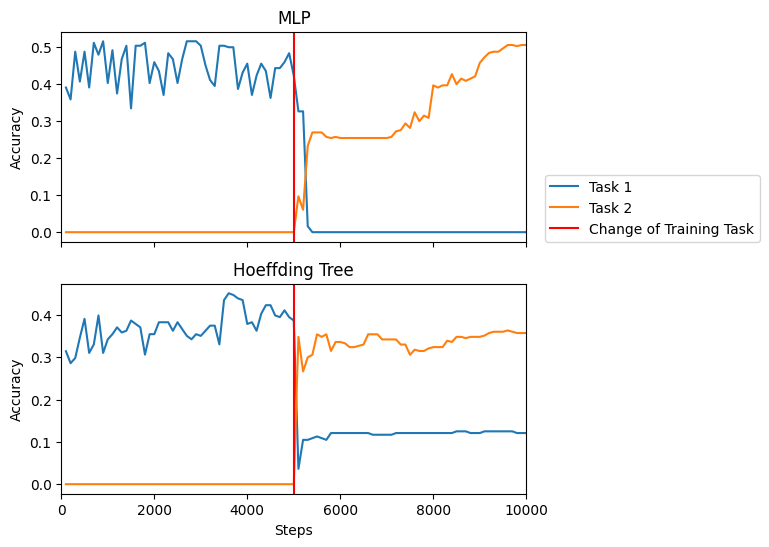

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
results = {"MLP": results_mlp, "Hoeffding Tree": results_tree}
for model_idx, (model_name, model_results) in enumerate(results.items()):
    ax = axs[model_idx]
    ax.plot(steps, model_results[0], label="Task 1")
    ax.plot(steps, model_results[1], label="Task 2")
    ax.axvline(5000, c="red", label="Change of Training Task")
    ax.set_ylabel("Accuracy")
    ax.set_title(model_name)
axs[-1].set_xlabel("Steps")
axs[-1].set_xlim(0, 10000)
axs[0].legend(loc=(1.04, 0))